# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')

Посмотрим на первые строки:

In [2]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Выведем информацию о датасете:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим общую гистограмму для всех числовых столбцов таблицы:

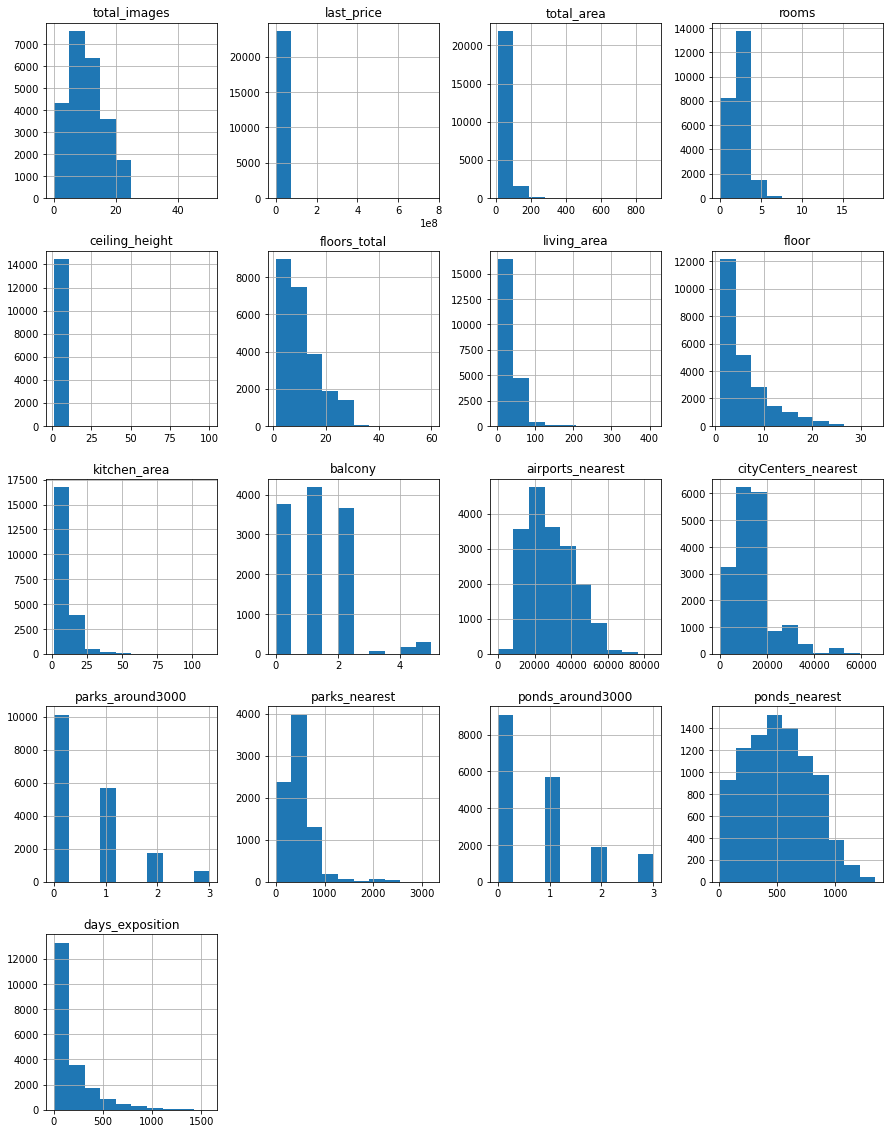

In [4]:
data.hist(figsize=(15, 20));

### Предобработка данных

Посмотрим, сколько имеется пропущенных значений в каждом из столбцов:

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим, что пропусков достаточно много и они имеются в разных столбцах. <br>
Однако для начала заменим названия населенных пунктов, чтобы избавиться от дубликатов и иметь возможность в бущуем заменять пропуски на медианные значения по населённому пункту.

Для этого сначала посмотрим на количество явных дубликатов в наших данных:

In [6]:
data.duplicated().sum()

0

Явных дубликатов нет. Тогда напишем функцию, которая по строке из столбца "locality_name" будет категоризировать данные по принадлежности к населённым пунктам:

In [7]:
sorted(data[data['locality_name'].isna()==False]['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городск

In [8]:
def distribute(locality_name):
    words = locality_name.split()
    result = []
    for word in words:
        if word[0].isupper():
            result.append(word)
    return ' '.join(result)
    

Удалим из нашего датасета строки, которые имеют пропуски в столбце 'locality_name', так как таких объявлений всего 49 и работать с ними будет сложно, так как мы не будем иметь информации о типичных значениях, которые стоило бы использовать для замены пропусков:

In [9]:
data.dropna(subset=['locality_name'], inplace = True)
data['locality_name'].isna().sum()

0

Применив пользовательскую функцию distribute к столбцу 'locality_name' нашего датафрейма, создадим новый столбце без дубликатов:

In [10]:
data['settlement_name'] = data['locality_name'].apply(distribute)

In [11]:
sorted(data['settlement_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпосёлок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичёво',
 'Иссад',
 'Калитино',

Отлично, теперь все объявления распределены по принадлежности к населённому пункту. Это можно использовать для замены пропусков на медианные значения по населённому пункту в дальнейшем.

Теперь начнём работу с пропусками. Еще раз посмотрим на столбцы с пропусками:

In [12]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area             2269
balcony                 11513
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
settlement_name             0
dtype: int64

Обратим внимание на количество комнат в столбце 'rooms'. Очевидно, что это значение не может быть равным 0, поэтому заменим все значения 0 на 1:

In [13]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

Продолжим работу с высоты потолков, где имеется аж 9160 пропущенных значений, что составляет значительную часть от исходной выборки. Построим ящик с усами чтобы посмотреть на выбросы:

In [14]:
data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

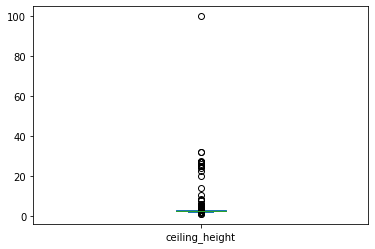

In [15]:
data['ceiling_height'].plot.box()

Вероятнее всего, значения высоты потолков в диапазоне от 20 до 40 метров являются просто ошибочными: так, высота потолка 25 метров в датасете могла означать высоту потолка, равную 2.5 метра, что уже больше похоже на правдоподобное значение <br>
Однако значения, большие 40 метров, уже не подойдут, потому что высота потолка, превышающая 4 метра - это уже редкость. <br> Посмотрим на эти значения:

Все значения, большие 10 метров, поделим на 10:

In [16]:
data.loc[data['ceiling_height']>10, 'ceiling_height'] /= 10

Значения, которые больше 4.5 или меньше 2 метров, мы удалим, так как их не так много:

In [17]:
data[(data['ceiling_height']>4.5) | (data['ceiling_height']<2)].shape[0]

23

In [18]:
data = data[(data['ceiling_height']<=4.5) & (data['ceiling_height']>=2) | (data['ceiling_height'].isna())]

Построим гистограмму распределения значений:

<AxesSubplot:>

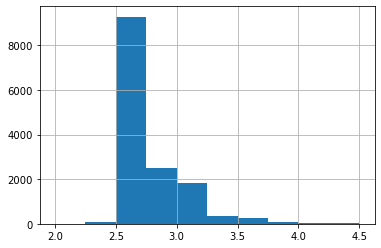

In [19]:
data['ceiling_height'].hist()

А проопуски мы попробуем заменить медианными значениями по соответствующему населённому пункту:

In [20]:
for city in data['settlement_name'].unique():
    data.loc[(data['settlement_name'] == city) & (data['ceiling_height'].isna()), 'ceiling_height'] \
    = data[data['settlement_name'] == city]['ceiling_height'].median()

Замечаем предупреждение о том, что по некоторым населённым пунктам не получилось найти медианное значение высоты потолка из-за отсутствия данных. Посмотрим, в скольких строках не получилось заполнить пропуски в столбце 'ceiling_height':

In [21]:
data['ceiling_height'].isna().sum()

95

Таких объявлений всего 95, да и расположены они в населённых пунктах, по которым у нас почти нет данных, поэтому избавимся от таких значений:

In [22]:
data.dropna(subset=['ceiling_height'], inplace=True)

Посмотрим на новое распределение высот потолков:

<AxesSubplot:>

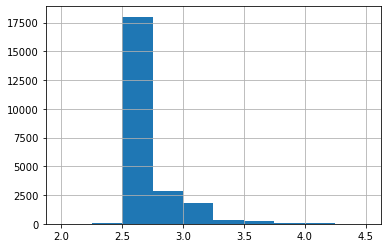

In [23]:
data['ceiling_height'].hist()

In [24]:
data['ceiling_height'].isna().sum()

0

Пропусков в столбце больше нет, а значит можно двигаться дальше!

Следующий столбец с пропусками - это столбец "floors_total". Посмотрим на наличие выбросов:

<AxesSubplot:>

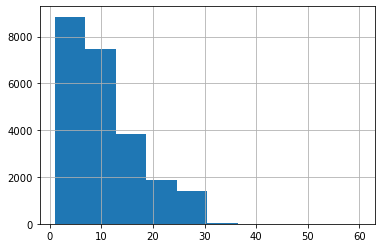

In [25]:
data['floors_total'].hist()

In [26]:
data['floors_total'].describe()

count    23447.000000
mean        10.703971
std          6.590968
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Посмотрим на строки с аномальными значениями, превышающими 40 этажей:

In [27]:
data[data['floors_total']>40].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,NaN,...,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0,Кронштадт
16731,9,3978000.0,40.0,2018-09-24T00:00:00,1,2.65,52.0,10.5,18,NaN,...,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0,Санкт-Петербург


Судя по городу, эти объявления не относятся к Москве-Сити, а значит таких больших значений в количестве этажей там быть не может. Удалим эти данные:

In [28]:
data = data[data['floors_total']<=40]

In [29]:
data['floors_total'].describe()

count    23445.000000
mean        10.700107
std          6.577853
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

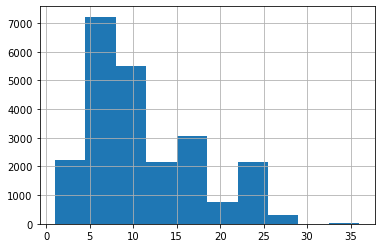

In [30]:
data['floors_total'].hist()

Выглядит достаточно естественно. Тогда теперь мы можем заменить все пропуски на медианное значение по населённому пункту:

In [31]:
for city in data['settlement_name'].unique():
    data.loc[(data['settlement_name'] == city) & (data['floors_total'].isna()), 'floors_total'] \
    = data[data['settlement_name'] == city]['floors_total'].median()

In [32]:
data['floors_total'].isna().sum()

0

Пропусков больше нет, а значит можно перейти к следующим столбцам.

In [33]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1840
floor                       0
is_apartment            20698
studio                      0
open_plan                   0
kitchen_area             2190
balcony                 11408
locality_name               0
airports_nearest         5430
cityCenters_nearest      5408
parks_around3000         5407
parks_nearest           15432
ponds_around3000         5407
ponds_nearest           14426
days_exposition          3146
settlement_name             0
dtype: int64

Можно заметить, что отсутствует достаточноое количество показателей в значении площадей: "living_area" и "kitchen_area" <br>
В исследовании мы можем заменить эти пропуски на значение 'total_area', умноженное на медианное отношение необходимой площади к общей площади квартиры по всем исходным данным. <br>
Однако для этого нам нужно очистить столбец 'total_area' от выбросов:

In [34]:
data['total_area'].describe()

count    23445.000000
mean        60.300353
std         35.417780
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Посмотрим также на диаграмму рассеивания, отложив по оси Х значения общей площади квартиры, а по оси Y значение количества комнат:

<AxesSubplot:xlabel='total_area', ylabel='rooms'>

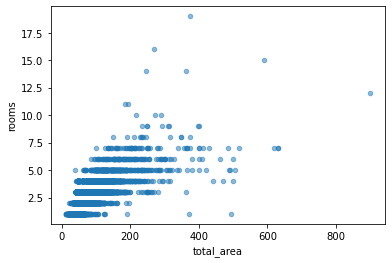

In [35]:
data.plot.scatter(x='total_area', y='rooms', alpha=0.5)

Отсюда мы видим, что значительная часть выборки имеет общую площадь, меньшую 350 квадратных метров и не более 7 комнат <br>
Удалим аномальные значения, так как их не так много (43 объявления):

In [36]:
data[(data['rooms'] > 7) | (data['total_area'] > 350)].shape[0]

63

In [37]:
data = data[(data['rooms'] <= 7) & (data['total_area'] <= 350)].copy()

Теперь мы можем рассчитать медианное отношение жилой площади к общей площади, а также медианное значение площади кухни к общей площади:

In [38]:
good_data = data[(~data['kitchen_area'].isna()) & (~data['living_area'].isna())].copy() # Создаём датафрейм без пропусков

In [39]:
proportion_1 = (good_data['living_area'] / good_data['total_area']).median()
proportion_2 = (good_data['kitchen_area'] / good_data['total_area']).median()

print(f'Медианная доля жилой площади к общей площади равна {proportion_1}')
print(f'Медианная доля кухонной площади к общей площади равна {proportion_2}')

Медианная доля жилой площади к общей площади равна 0.566408393935236
Медианная доля кухонной площади к общей площади равна 0.17215047943086917


Теперь у нас есть необходимые медианные доли и мы можем заполнить пропуски в столбцах 'living_area' и 'kitchen_area':

In [40]:
data['living_area'].fillna(value=(data['total_area'] * proportion_1), inplace=True)
data['kitchen_area'].fillna(value=(data['total_area'] * proportion_2), inplace=True)

Заметим, что имеются строки, в которых общая площадь меньше суммы жилой и кухонной:

In [41]:
data[data['total_area']<(data['living_area']+data['kitchen_area'])].shape[0]

114

Исправим площади для таких строк: заменим кухонную площадь на разность общей площади и жилой площади:

In [42]:
data.loc[data['total_area']<(data['living_area']+data['kitchen_area']), 'kitchen_area'] =\
data['total_area']-data['living_area']

In [43]:
data[data['total_area']<(data['living_area']+data['kitchen_area'])].shape[0]

0

Отлично, идём дальше

In [44]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20639
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11372
locality_name               0
airports_nearest         5427
cityCenters_nearest      5406
parks_around3000         5405
parks_nearest           15414
ponds_around3000         5405
ponds_nearest           14400
days_exposition          3129
settlement_name             0
dtype: int64

Теперь мы можем перейти к столбцу "is_apartment", который показывает, является ли квартира апартаментами. Посмотрим на количество значений в этом столбце:

In [45]:
data['is_apartment'].value_counts()

False    2695
True       48
Name: is_apartment, dtype: int64

Отсюда можно сделать вывод, что количество квартир-апартаментов крайне мало, а значит все пропуски можно заменить на False:

In [46]:
data['is_apartment'].fillna(value=False, inplace=True)

Аналогично можно поступить и со столбцом 'balcony' (если не указано количество балконов, то вероятнее всего их просто нет):

In [47]:
data['balcony'].value_counts()

1.0    4156
0.0    3650
2.0    3641
5.0     301
4.0     182
3.0      80
Name: balcony, dtype: int64

In [48]:
data['balcony'].fillna(value=0, inplace=True)

Проверим, что пропусков не осталось:

In [49]:
data['balcony'].isna().sum()

0

А также поменяем тип данных на int, так как количество балконов можно измерить только натуральным числом:

In [50]:
data['balcony'] = data['balcony'].astype('int').copy()

Проверим, что тип данных столбца изменился:

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23382 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23382 non-null  int64  
 1   last_price            23382 non-null  float64
 2   total_area            23382 non-null  float64
 3   first_day_exposition  23382 non-null  object 
 4   rooms                 23382 non-null  int64  
 5   ceiling_height        23382 non-null  float64
 6   floors_total          23382 non-null  float64
 7   living_area           23382 non-null  float64
 8   floor                 23382 non-null  int64  
 9   is_apartment          23382 non-null  bool   
 10  studio                23382 non-null  bool   
 11  open_plan             23382 non-null  bool   
 12  kitchen_area          23382 non-null  float64
 13  balcony               23382 non-null  int64  
 14  locality_name         23382 non-null  object 
 15  airports_nearest   

Однако теперь нужно убрать выбросы из столбца 'balcony'. Для начала построим диаграмму рассеивания для значений площади квартиры и количества балконов в ней:

<AxesSubplot:xlabel='balcony', ylabel='total_area'>

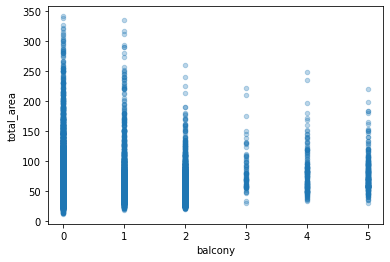

In [52]:
data.plot.scatter(x='balcony', y='total_area', alpha=0.3)

Сложно представить квартиру площадью менее 50 кв. метров, в которой 4 или 5 балконов... <br>
Однако всё же сложно сказать, ошибка ли это или нет, поэтому пока такие данные убирать не будем

Итак, посмотрим на оставшиеся столбцы с пропусками:

In [53]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5427
cityCenters_nearest      5406
parks_around3000         5405
parks_nearest           15414
ponds_around3000         5405
ponds_nearest           14400
days_exposition          3129
settlement_name             0
dtype: int64

Оставшиеся столбцы (за исключением "days_exposition") относятся к картографическим данным и ничего страшного в том, что в них имеются пропуски, нет. На мой взгляд, **не стоит удалять** такой значительный объём данных, если в них есть пропуск в картографических показателях. <br>
Аналогично не стоит удалять данные из-за пропусков в столбце days_exposition, так как не для всех исследований нам пригодится именно этот показатель.

Осталось лишь изменить тип данных в столбце first_day_exposition, чтобы перевести его в формат DateTime:

In [54]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23382 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23382 non-null  int64         
 1   last_price            23382 non-null  float64       
 2   total_area            23382 non-null  float64       
 3   first_day_exposition  23382 non-null  datetime64[ns]
 4   rooms                 23382 non-null  int64         
 5   ceiling_height        23382 non-null  float64       
 6   floors_total          23382 non-null  float64       
 7   living_area           23382 non-null  float64       
 8   floor                 23382 non-null  int64         
 9   is_apartment          23382 non-null  bool          
 10  studio                23382 non-null  bool          
 11  open_plan             23382 non-null  bool          
 12  kitchen_area          23382 non-null  float64       
 13  balcony         

Но это еще не всё! 

Взглянув на гистограммы из начала, сразу же можно обнаружить выбросы в столбце "last_price".

Напомню, как выглядит гистограмма:

<AxesSubplot:>

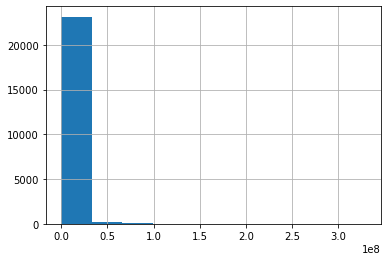

In [56]:
data['last_price'].hist()

Исправим это. Для начала выведем информацию о столбце:

In [57]:
data['last_price'].describe()

count    2.338200e+04
mean     6.318730e+06
std      7.796983e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.750000e+06
max      3.300000e+08
Name: last_price, dtype: float64

Построим ящик с усами:

<AxesSubplot:>

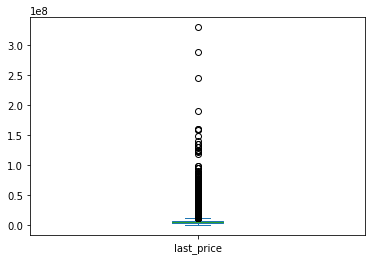

In [58]:
data['last_price'].plot.box()

Хотелось бы отбросить значения, которые относятся к выбросам. Однако для начала посмотрим, сколько данных находится выше 3-го квартиля, увеличенного на 1.5 интерквартильного размаха (именно эти значения на ящике с усами являются выбросами):

In [59]:
iqr = data['last_price'].quantile(q=0.75)-data['last_price'].quantile(q=0.25)
(data['last_price']>(1.5*iqr + data['last_price'].quantile(q=0.75))).sum()

2006

Это составляет почти 10% от нашей выборки, что достаточно много. Однако нам все же придется удалить часть наибольших выбросов, чтобы не учитывать такие космические цены в дальнейшем ислледовании, поэтому мы удалим данные, превышающие 2.5 интерквартильного размаха:

In [60]:
(data['last_price']>(2.5*iqr + data['last_price'].quantile(q=0.75))).sum()

1124

Таких данных уже меньше, что составляет лишь ~5% от исходной выборки. Удалим их:

In [61]:
data = data[data['last_price']<=(2.5*iqr + data['last_price'].quantile(q=0.75))].copy()

Отлично, ну и напоследок изменим тип данных в столбцах 'parks_around3000' и 'ponds_around3000' на int, так как количество прудов и парков рядом может быть только целым числом (аналогично поступим с общим количеством этажей в доме):

In [62]:
data['parks_around3000'] = data['parks_around3000'].astype(dtype='Int64').copy()
data['ponds_around3000'] = data['ponds_around3000'].astype(dtype='Int64').copy()
data['floors_total'] = data['floors_total'].astype('int').copy()

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22258 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22258 non-null  int64         
 1   last_price            22258 non-null  float64       
 2   total_area            22258 non-null  float64       
 3   first_day_exposition  22258 non-null  datetime64[ns]
 4   rooms                 22258 non-null  int64         
 5   ceiling_height        22258 non-null  float64       
 6   floors_total          22258 non-null  int64         
 7   living_area           22258 non-null  float64       
 8   floor                 22258 non-null  int64         
 9   is_apartment          22258 non-null  bool          
 10  studio                22258 non-null  bool          
 11  open_plan             22258 non-null  bool          
 12  kitchen_area          22258 non-null  float64       
 13  balcony         

In [64]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5405
cityCenters_nearest      5390
parks_around3000         5389
parks_nearest           15067
ponds_around3000         5389
ponds_nearest           14065
days_exposition          2793
settlement_name             0
dtype: int64

Посмотрим, какая доля от исходного количества строк сохранилась для дальнейшего анализа:

In [65]:
data.shape[0]/23968

0.9286548731642189

Осталось почти 93%, что достаточно неплохо. На этом предобработку данных можно завершить и перейти к следующему этапу.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим новый столбец со днём недели даты публикации:

In [66]:
data['publication_week_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

In [67]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name,publication_week_day
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,3
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,False,...,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,1
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,3
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,1
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,городской посёлок Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55.0,Янино-1,0


Аналогично добавим столбцы с месяцем и годом публикации объявления:

In [68]:
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

Посмотрим на результат:

In [69]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name,publication_week_day,publication_month,publication_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,False,...,18603.0,0,NaN,0,NaN,81.0,Шушары,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,3,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,1,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,<NA>,NaN,<NA>,NaN,55.0,Янино-1,0,9,2018


Теперь напишем функцию для категоризации квартиры по её этажу (первый, последний или другой):

In [70]:
def floor_categorize(data):
    if data['floor']==1:
        return 'Первый'
    if data['floor']==data['floors_total']:
        return 'Последний'
    return 'Другой'

In [71]:
data['floor_type'] = data.apply(floor_categorize, axis=1)

In [72]:
data[data['floor_type']=='Последний'].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name,publication_week_day,publication_month,publication_year,floor_type
12,10,3890000.0,54.0,2016-06-30,2,2.60,5,30.0,5,False,...,<NA>,NaN,<NA>,NaN,90.0,Сертолово,3,6,2016,Последний
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,1,294.0,3,298.0,366.0,Петергоф,5,7,2017,Последний
23,11,2950000.0,32.0,2016-10-29,1,2.60,9,17.7,9,False,...,2,517.0,1,190.0,615.0,Санкт-Петербург,5,10,2016,Последний
36,13,3790000.0,45.0,2017-01-25,2,2.70,9,27.0,9,False,...,1,459.0,0,NaN,139.0,Санкт-Петербург,2,1,2017,Последний
43,13,9330000.0,48.0,2017-01-10,2,3.00,4,28.0,4,False,...,0,NaN,1,492.0,763.0,Санкт-Петербург,1,1,2017,Последний


Аналогично напишем и применим функцию для рассчёта цены одного квадратного метра:

In [73]:
def calculate_meter_price(data):
    return data['last_price'] / data['total_area']

In [74]:
data['meter_price'] = data.apply(calculate_meter_price, axis=1)

А также перезапишем столбец "cityCenters_nearest" для перевода расстояниия до центра города в километры:

In [75]:
data['cityCenters_nearest'].head()

0    16028.0
1    18603.0
2    13933.0
4     8098.0
5        NaN
Name: cityCenters_nearest, dtype: float64

In [76]:
data['cityCenters_nearest'] = round(data['cityCenters_nearest'] / 1000)

Отлично, теперь наши объявления выглядят следующим образом, а значит мы готовы их исследовать:

In [77]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name,publication_week_day,publication_month,publication_year,floor_type,meter_price
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,NaN,Санкт-Петербург,3,3,2019,Другой,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,False,...,NaN,0,NaN,81.0,Шушары,1,12,2018,Первый,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,90.0,2,574.0,558.0,Санкт-Петербург,3,8,2015,Другой,92785.714286
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121.0,Санкт-Петербург,1,6,2018,Другой,100000.000000
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,<NA>,NaN,55.0,Янино-1,0,9,2018,Другой,95065.789474


### Проведите исследовательский анализ данных

**Общая площадь**

count    22258.000000
mean        55.225351
std         21.962989
min         12.000000
25%         39.400000
50%         50.200000
75%         65.900000
max        320.000000
Name: total_area, dtype: float64

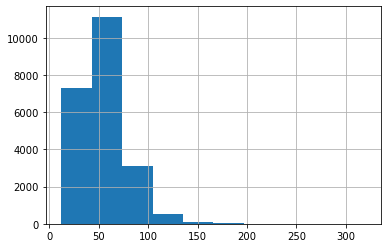

In [78]:
data['total_area'].hist()
data['total_area'].describe()

Заметно, что значительная часть квартир имеет общую площадь от 40 до 66 кв. метров, в то время как самые большие площади могут достигать до 320 квадратных метров

**Жилая площадь**

count    22258.000000
mean        31.673980
std         14.976458
min          2.000000
25%         18.600000
50%         29.700000
75%         40.000000
max        190.000000
Name: living_area, dtype: float64

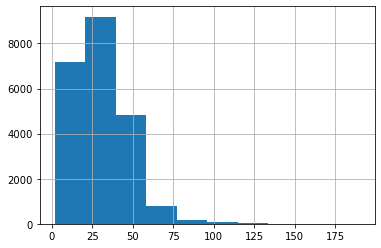

In [79]:
data['living_area'].hist()
data['living_area'].describe()

Стандартное отклонение жилой площади уже меньше, чем у общей площади, а значит здесь ситуация более "стабильная" и значения сосредоточены возле средней жилой площади, равной 31 квадратный метр

**Площадь кухни**

count    22258.000000
mean         9.752575
std          4.259153
min          0.000000
25%          7.000000
50%          9.000000
75%         11.189781
max        100.700000
Name: kitchen_area, dtype: float64

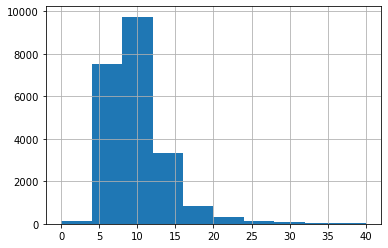

In [80]:
data['kitchen_area'].hist(range=(0,40))
data['kitchen_area'].describe()

А здесь стандартное отклонение значительно меньше (всего 4.2 кв. метра), что говорит о том, что кухня у большинства квартир имеет незначительный разброс в площади и примерно составляет ~9.7 кв. метра <br>
Стоит отметить, что имеются аномальные значения более 50 кв. метров,  однако они соответствует огромным квартирам с общей площадью более 100 кв.метров

In [81]:
data[data['kitchen_area']>50].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,settlement_name,publication_week_day,publication_month,publication_year,floor_type,meter_price
2489,9,12500000.0,255.0,2017-04-21,3,2.7,2,153.9,2,False,...,NaN,3,198.0,102.0,Санкт-Петербург,4,4,2017,Последний,49019.607843
3561,5,12300000.0,115.0,2017-08-09,3,2.7,20,45.0,16,False,...,NaN,0,NaN,63.0,Санкт-Петербург,2,8,2017,Другой,106956.521739
15780,9,12990000.0,119.6,2017-03-13,3,3.0,5,36.4,4,False,...,569.0,0,NaN,NaN,Пушкин,0,3,2017,Другой,108612.040134
19499,10,8000000.0,118.0,2017-08-31,3,3.0,5,36.0,4,False,...,569.0,0,NaN,7.0,Пушкин,3,8,2017,Другой,67796.610169
20636,10,13500000.0,135.0,2017-08-19,3,3.0,12,52.4,11,False,...,156.0,0,NaN,101.0,Санкт-Петербург,5,8,2017,Другой,100000.000000


**Цена объекта**

count    2.225800e+04
mean     5.172667e+06
std      2.707844e+06
min      1.219000e+04
25%      3.390000e+06
50%      4.500000e+06
75%      6.300000e+06
max      1.500000e+07
Name: last_price, dtype: float64

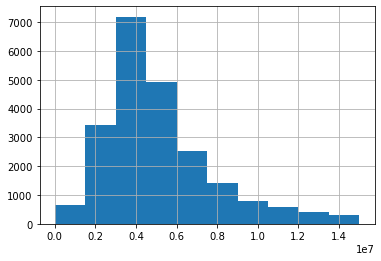

In [82]:
data['last_price'].hist()
data['last_price'].describe()

Отчётливо видно, что форма кривой гистограммы напоминает Гауссову функцию, а значит можно выдвинуть гипотезу о нормальном распределении цены квартиры со средней ценой 5.17 миллионов и стандартным отклонением, равным 2.7 миллиона

**Количество комнат**

count    22258.000000
mean         1.987241
std          0.936794
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

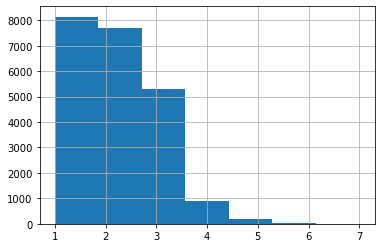

In [83]:
data['rooms'].hist(bins=7)
data['rooms'].describe()

Обычно в квартирах есть 1-3 комнаты, значительно реже встречаются квартиры с 4 и больше комнатами

**Высота потолков**

count    22258.000000
mean         2.686007
std          0.195236
min          2.000000
25%          2.550000
50%          2.700000
75%          2.700000
max          4.500000
Name: ceiling_height, dtype: float64

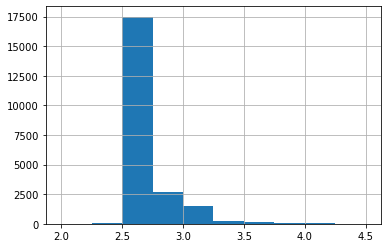

In [84]:
data['ceiling_height'].hist()
data['ceiling_height'].describe()

В среднем высота потолков составляет ~2.7 метра, что очень даже соответствует реальности. Но кроме того имеются и квартиры (возможно, элитного класса), в которых высота потолка превышает 3-4 метра. Относительно низкое стандартное отклонение показыает, что разброс тут не такой большой

**Этаж квартиры**

count    22258.000000
mean         5.893477
std          4.897707
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

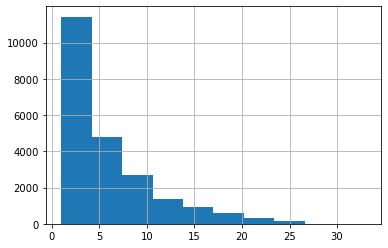

In [85]:
data['floor'].hist()
data['floor'].describe()

По гистограмме можно предположить, что распределение имеет правостороннюю асимметрию, т.е. значения стремятся больше к минимуму, чем к максимуму. Высокое значение стандартного отклонения говорит о том, что значения могут сильно отличаться от среднего значения (6 этаж)

**Тип этажа квартиры**

count      22258
unique         3
top       Другой
freq       16365
Name: floor_type, dtype: object

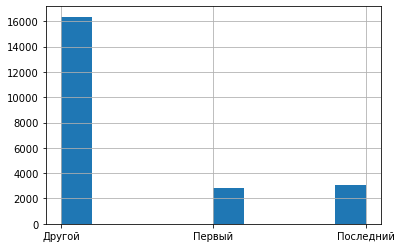

In [86]:
data['floor_type'].hist()
data['floor_type'].describe()

В целом, тут всё как и ожидалось: преобладают квартиры, расположенные не на первом и не на последнем этаже.

**Количество этажей в доме**

count    22258.000000
mean        10.781966
std          6.622393
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

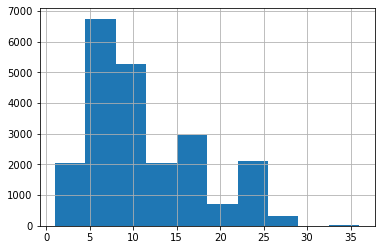

In [87]:
data['floors_total'].hist()
data['floors_total'].describe()

Количество этажей в домах достаточно сильно разбросано: между 3-им и 1-ым квартилями находятся дома, имеющие от 5 до 16 этажей, что подтверждается также и стандартным отклонением, равным ~6.6 этажей

**Расстояние до центра города**

count    16868.000000
mean        14.663920
std          8.568189
min          0.000000
25%         10.000000
50%         13.000000
75%         17.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

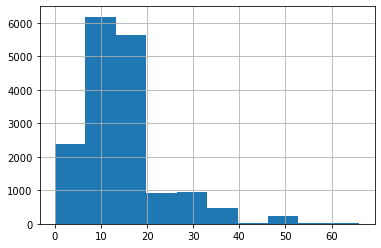

In [88]:
data['cityCenters_nearest'].hist()
data['cityCenters_nearest'].describe()

В среднем, квартиры расположены в 14.6 км от центра города, однако разброс значений достаточно большой.

**Расстояние до ближайшего аэропорта**

count    16853.000000
mean     28863.708183
std      12867.093431
min          0.000000
25%      18271.000000
50%      26904.000000
75%      37459.000000
max      84869.000000
Name: airports_nearest, dtype: float64

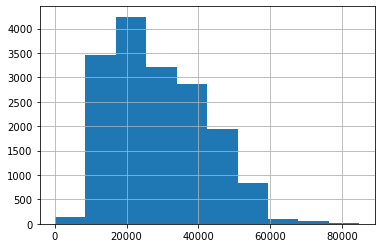

In [89]:
data['airports_nearest'].hist()
data['airports_nearest'].describe()

В среднем квартиры расположена в 28-километровой доступности от аэропорта, но разброс значений здесь просто огромный, поэтому в межквартильный размах попадают квартиры с расстоянием до аэропорта от 18 до 37 км. <br>
Не стоит забывать, что в этом столбце имеется около 5 тысяч пропущенных значений, но удалять мы их не стали

**Расстояние до ближайшего парка**

count    7191.000000
mean      491.202058
std       335.310913
min         1.000000
25%       290.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

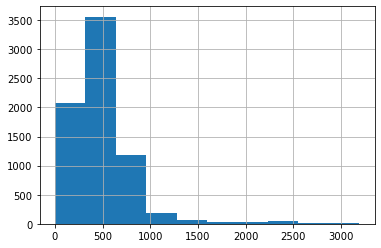

In [90]:
data['parks_nearest'].hist()
data['parks_nearest'].describe()

Интересно отметить, что почти у всех квартир имеется парк в километровой доступности.

**День и месяц публикации**

<AxesSubplot:xlabel='publication_month', ylabel='publication_week_day'>

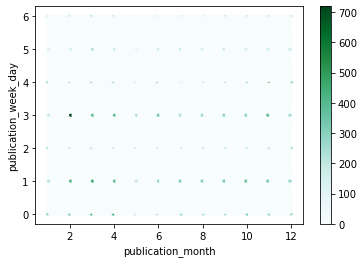

In [91]:
data.plot.hexbin(x='publication_month', y='publication_week_day', sharex=False)

Сложно сделать какой-либо вывод из такой диаграммы рассеивания. Видно лишь то, что от дня недели не сильно зависит количество объявлений, а в феврале и марте количество объявлений немного увеличивается за счёт новых публикаций. <br> Конечно, можно отметить, что больше всего объявлений было выложено в четверг февраля. 

<AxesSubplot:>

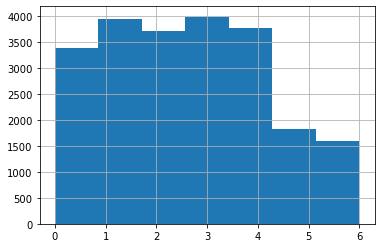

In [92]:
data['publication_week_day'].hist(bins=7)

Видно лишь то, что в субботу и воскресенье реже всего появляются новые объявления

<AxesSubplot:>

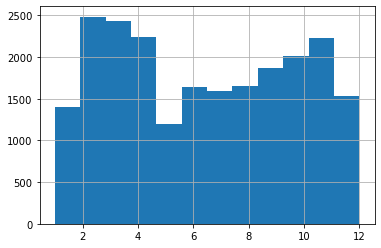

In [93]:
data['publication_month'].hist(bins=12)

По месяцам всё тоже распределено примерно равномерно, однако в январе и мае объявлений размещается меньше всего

**Изучим, как долго продавались квартиры**

Для начала построим гистограмму:

<AxesSubplot:>

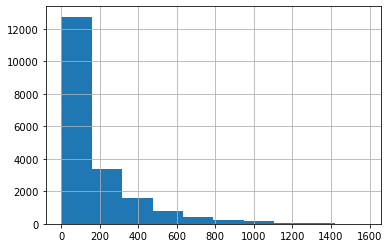

In [94]:
data['days_exposition'].hist()

Видим, что значительная часть квартир продаётся менее, чем за ~полгода

Рассчитаем среднее и медиану:

In [95]:
print(f'Среднее: {data["days_exposition"].mean()}')
print(f'Медиана: {data["days_exposition"].median()}')

Среднее: 176.39306447469818
Медиана: 93.0


Можно увидеть, что наибольшие значения ощутимо "тянут" среднее верх

Дополнительно построим диаграмму размаха:

<AxesSubplot:>

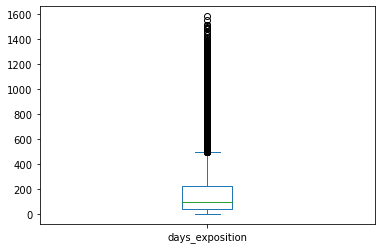

In [96]:
data['days_exposition'].plot.box()

Видим, что аномально долгими продажами можно считать те продажи, что отклоняются от 3-го квартиля более чем на 1.5 межквартильного размаха. Рассчитаем, какие продажи можно считать долгими, а какие - быстрыми:

In [97]:
iqr = data['days_exposition'].quantile(0.75) - data['days_exposition'].quantile(0.25)
print(f'Долгая продажа: от {int(data["days_exposition"].quantile(0.75)+iqr*1.5)} дней')
print(f'Быстрая продажа: до {int(data["days_exposition"].quantile(0.25))} дней')
print(f'В среднем продажа занимает от {int(data["days_exposition"].quantile(0.25))} до {int(data["days_exposition"].quantile(0.75))} дней')

Долгая продажа: от 494 дней
Быстрая продажа: до 44 дней
В среднем продажа занимает от 44 до 224 дней


Теперь рассмотрим, **какие факторы больше всего влияют на общую стоимость объекта**

**Общая площадь**

Построим диаграмму рассеивания:

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

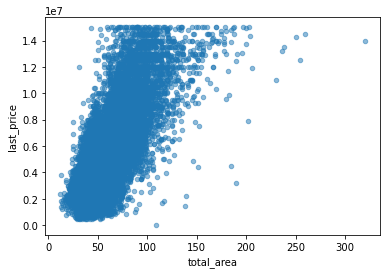

In [98]:
data.plot.scatter(x='total_area', y='last_price', alpha=0.5)

Видно, что в целом с увеличение общей площади стремительно растёт и цена квартиры. <br>
Рассчитаем линейный коэффициент корреляции Пирсона:

In [99]:
data['total_area'].corr(data['last_price'])

0.7456887706509738

Наше предположение подтвердилось значением коэффициента корреляции, близким к единице. Следовательно, **с увеличением общей площади растёт и цена на квартиру

**Жилая площадь**

Аналогично построим диаграмму рассеивания:

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

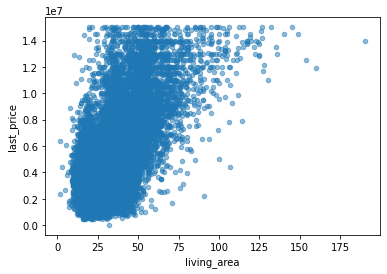

In [100]:
data.plot.scatter(x='living_area', y='last_price', alpha=0.5)

Заметно, что с увеличением жилой площади квартиры растёт и её цена, но уже не так стремительно, как это было с общей площадью. <br>
Рассчитаем линейный коэффициент корреляции Пирсона:

In [101]:
data['living_area'].corr(data['last_price'])

0.6407284259315587

Наше предположение также подтвердилось значением коэффициента корреляции, а значит **с увеличением жилой площади также увеличивается и цена**, однако уже не так стремительно, как это было в случае с общей площадью

**Площадь кухни**

И снова построим диаграмму рассеивания:

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

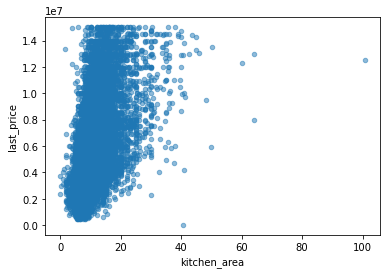

In [102]:
data.plot.scatter(x='kitchen_area', y='last_price', alpha=0.5)

А вот тут уже зависимость не такая сильная: мы видим, что имеется много квартир с большой кухней, однако цена у них всё равно значительно отличается. <br>
Рассчитаем линейный коэффициент корреляции Пирсона:

In [103]:
data['kitchen_area'].corr(data['last_price'])

0.5569980557927231

Коэффициент ниже, чем было в случаях с общей и жилой площадью, следовательно **цена растёт с увиличением площади кухни**, но уже не так сильно, как цена растёт при увеличении общей или жилой площади

**Количество комнат**

Сгруппируем объявления по количеству комнат в квартире и рассчитаем среднюю стоимость:

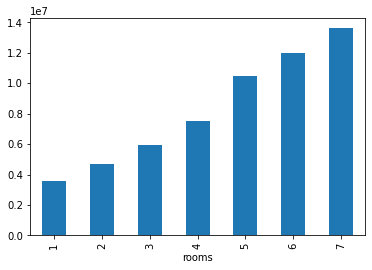

In [104]:
data.groupby('rooms')['last_price'].median().plot.bar();

На графике отчётливо видно, что с ростом количества комнат в квартире линейно растёт и её стоимость. Это также подтверждается и значительным коэффициентом линейной корреляции:

In [105]:
data['rooms'].corr(data['last_price'])

0.49378604476864685

Коэффициент линейной корреляции Пирсона равен примерно 0.5, а значит что **количество комнат напрямую влияет на стоимость квартиры, но не так сильно**.

**Этаж, на котором расположена квартира**

Аналогично, сгруппируем объявления по этажу квартиры и рассчитаем среднюю стоимость:

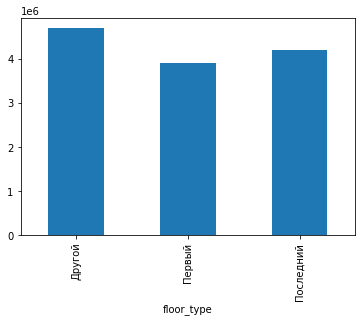

In [106]:
data.groupby('floor_type')['last_price'].median().plot.bar();

Здесь очень сложно рассмотреть какую-то зависимость. Можно лишь отметить, что квартиры, расположенные на первом этаже, обычно не могут стоить дороже, чем на более высоких этажах. <br>
Коэффициент корелляции мы рассчитать не можем, так как в столбце "floor_type" содержатся категориальные строковые переменные.

Однако мы можем построить диаграмму рассеивания и коэффициент линейной корелляции для номера этажа, на котором расположена квартира:

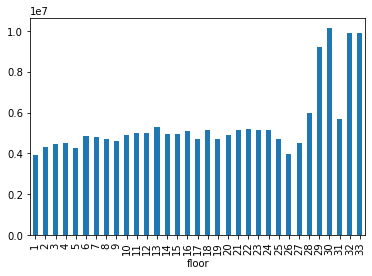

In [107]:
data.groupby('floor')['last_price'].median().plot.bar();

Таким образом, **этаж квартиры почти не влияет на ее стоимость**, однако квартиры на первом этаже, как правило, не могут стоить дорого, а на аномально высоких этажах стомость квартиры может быть значительно выше.

**Дата размещения объявления**

Посмотрим, как зависит цена квартиры от дня недели размещения:

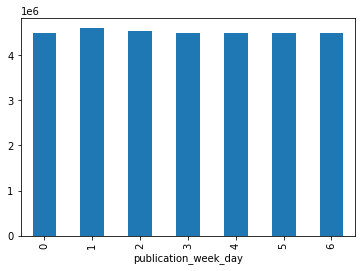

In [108]:
data.groupby('publication_week_day')['last_price'].median().plot.bar();

Как и можно было предположить, цена квартиры не зависит от дня недели, в который было выложено объявление

Теперь посмотрим на зависимость цены от месяца размещения объявления:

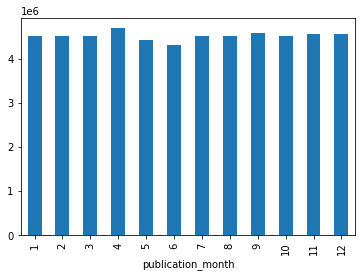

In [109]:
data.groupby('publication_month')['last_price'].median().plot.bar();

Явной зависимости всё так же нет.

Ну и, наконец, посмотрим как менялась цена с на квартиры с каждым годом:

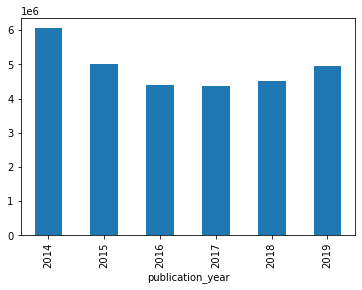

In [110]:
data.groupby('publication_year')['last_price'].median().plot.bar();

По такой диаграмме видно, что зависимость здесь не совсем линейная, поэтому коэффициент корелляции тут не поможет. Однако кажется, что в последние два года (2018-2019) цены на квартиры в среднем немного растут.

Таким образом, **на цену квартиры значительно влияет её общая площадь, а также жилая площадь и площадь кухни**. А от количества комнат, этажа квартиры и даты размещения объявления цена почти не зависит.

Теперь выполним задание **Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра** <br>
Для начала отберём 10 населённых пунктов с наибольшим числом объявлений:

In [111]:
pop_settlements = data['settlement_name'].value_counts().head(10).index
pop_settlements

Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг'],
      dtype='object')

Затем построим сводную таблицу для этих 10 населённых пунктов со средней стоимостью одного квадратного метра

In [112]:
data.query('settlement_name in @pop_settlements')\
.pivot_table(index='settlement_name', values='meter_price', aggfunc='mean')\
.sort_values(by='meter_price', ascending=False)

,meter_price
settlement_name,
Санкт-Петербург,107213.168949
Пушкин,101197.271132
Кудрово,95260.846171
Парголово,90175.913458
Мурино,86041.116064
Шушары,78551.344545
Колпино,75333.295801
Гатчина,68746.146763
Всеволожск,67214.252635


Теперь мы можем увидеть, что самая низкая средняя цена (для 10 населённых пунктов с наибольшим числом объявлений) характера для города Выборг, где средняя цена одного квадратного метра составляет ~58 тыс. рублей <br>
Самым дорогим, как и стоило ожидать, получился Санкт-Петербург - там средняя цена одного квадратногоо метра составила 107 тыс. рублей, что почти в 2 раза больше, чем в Выборге

Теперь выполним задание **"Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."**

Отберём подходящие объявления и для них рассчитаем среднюю цену каждого километра:

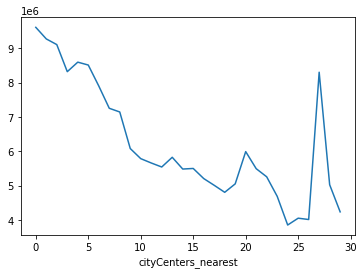

In [113]:
filtered = data[data['settlement_name']=='Санкт-Петербург'].copy()
filtered.groupby('cityCenters_nearest')['last_price'].mean().plot.line();

Что и стоило ожидать: с увеличением расстояния до центра города уменьшается цена на квартиру, однако на 26-27 километрах есть какое-то аномальное повышение цены. Возможно, там находится какой-нибудь дорогой район, где цены на квартиры значительно выше, чем в соседних районах

In [114]:
data['cityCenters_nearest'].corr(data['last_price'])

-0.3573521667399977

Отрицательный коэффициент линейной корреляции Пирсона это подтверждает: **с увеличением рассстоения от квартиры до центра города падает цена на эту квартиру**, хотя связь и несильная.

### Общий вывод

Изучив данные, мы избавились от большого количества пропусков и аномальных значений и при этом сохранили более 90% исходных данных, тем самым подготовив всё для исследовательского анализа. Также мы избавились от неявных дубликатов и добавили новые вспомогательные столбцы.

Далее мы изучили главные показатели объявлений о квартирах и выяснили, как выглядит среднестатистическая квартира в Санкт-Петербурге и областях, которую выставили на продажу:

- Общая площадь от 40 до 66 квадратных метров
- Жилая площадь занимает чуть больше половины от общей площади (56%)
- Кухня занимает примерно 17% от всей общей площади квартиры
- Стоимость обычно находится в диапазоне от 3.4 до 6.3 миллионов рублей
- Как правило не более 3-х комнат
- Стандартная высота потолков ~2.7 метра
- Квартира редко находится выше 8-го этажа, при этом в самом доме обычно не более 10 этажей
- Не в центре города и достаточно далеко от аэропорта (от 18 км.)
- Имеется парк в километровой доступности (или двух)

<br>
Сами объявления выкладываются значительно чаще в будние дни, а также их количество не сильно зависит от месяца (хотя в январе и мае объявлений меньше всего). <br>
Сами квартиры чаще всего продаются от 44 до 224 дней. Быстрыми можно считать те, что продаются быстрее, чем за 44 дня, а долгие "продажи" и вовсе могут занимать более целого года

<br> Не менее важно было выделить факторы, которые влияют на цену квартиры больше всего. На основе линейных коэффициентов корреляции Пирсона и диаграмм рассеивания было выяснено, что:

- Общая площадь квартиры сильно влияет на цену: с увеличением площади, как правило, растёт и стоимость квартиры;
- Жилая площадь и площадь кухни также влияет на цену, но уже не так сильно;
- Количество комнат не сильно влияет на стоимость, так как она в первую очередь определяется именно площадью;
- Этаж, на котором расположена квартира, почти не влияет на ее стоимость (по сравнению с площадью);
- Цена квартиры практически не зависит линейно от даты размещения объявления (возможно, связь более сложная);
- Чем дальше квартира от центра города, тем меньше её стоимость. Удаление квартиры от города на 1 километр в среднем понижает её стоимость на 433 тысячи рублей

<br>
Самые дорогие квартиры, как и ожидалось, находятся в Санкт-Петербурге, где средняя цена одного квадратного метра составляет 107 тысяч рублей, когда, например, в Выборге цена квадратного метра почти в 2 раза меньше (там она составляет 58 тысяч рублей)

Данные статистические выводы можно использовать, чтобы прогнозировать оптимальную по рынку стоимость продаваемой квартиры, а также для того, чтобы отобрать объявления мошенников на платформах для продажи недвижимости.

P.S.: я заметил, что в некоторых блоках с кодом появляются различные предупреждения (например о том, что я работаю с ссылками на другой датафрейм), но, насколько я заметил, это не влияет на результаты исследования.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод